In [1]:
import pm4py
import pandas as pd
import datetime
from math import ceil
import matplotlib.pyplot as plt
import torch
import numpy as np
import gym
from importlib import reload
import random
from random import shuffle


from IPython import display

# Data
## Download and read
- Download `.xes` file(archive) from [here](https://data.4tu.nl/articles/dataset/BPI_Challenge_2012/12689204)
- Read this `.xes`
- Convert to good old `.csv`

## Drop data
In the article only (activity, time_stamp) is used. Also leave trace id

In [2]:
try:
    df = pd.read_csv('bpi_12.csv')
    df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.fromisoformat(x))
except FileNotFoundError:
    file_path = 'BPI_Challenge_2012.xes'
    event_log = pm4py.read_xes(file_path)
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    df = pm4py.convert_to_dataframe(event_log)
    df = df[['time:timestamp', 'case:concept:name', 'concept:name']]
    df = df.rename(columns={'time:timestamp': 'timestamp', 'case:concept:name': 'trace_id', 'concept:name': 'activity'})
    df['trace_id'] = df['trace_id'].apply(lambda x: int(x))
    df.to_csv('bpi_12.csv', index=False)

## Time-related features

- $t_{w}$ - time passed between Sunday midnight and the event
- $t_e$ - time passed between the completion of the given event and the completion of the previous one
- $t_t$ - time passed between the start of the trace and the given event

### $t_w$

In [3]:
def get_t_w(df):
    _df = df.copy()
    _dt_s_mn = _df['timestamp'].apply(lambda x: (x - x.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds())
    _dt_s_mn += _df['timestamp'].apply(lambda x: x.weekday() * 24 * 60 * 60)
    return _dt_s_mn.values

In [4]:
tw = get_t_w(df)

### $t_e$

In [5]:
def get_t_e(df):
    te = df['timestamp'].copy().diff()
    tr_diff = df['trace_id'].diff().fillna(1)
    te[tr_diff != 0] = 0.
    return te.values * 1e-9

In [6]:
te = get_t_e(df)

### $t_t$

In [7]:
def get_t_t(df):
    traces = list(set(df['trace_id']))
    out = df.copy()[['timestamp', 'trace_id']]
    t_ts = {}
    for t in traces:
        t_ts[t] = df['timestamp'][df['trace_id'] == t].min()
    out['tt'] = out.apply(lambda x: (x['timestamp'] - t_ts[x['trace_id']]).total_seconds(), axis=1)
    return out['tt'].values

In [8]:
tt = get_t_t(df)

In [9]:
df['tt'] = tt
df['te'] = te
df['tw'] = tw

In [10]:
n_classes = len(set(df['activity']))

In [11]:
df.head()

,timestamp,trace_id,activity,tt,te,tw
0,2011-10-01 00:38:44.546000+02:00,173688,A_SUBMITTED,0.000,0.000,434324.546
1,2011-10-01 00:38:44.880000+02:00,173688,A_PARTLYSUBMITTED,0.334,0.334,434324.880
2,2011-10-01 00:39:37.906000+02:00,173688,A_PREACCEPTED,53.360,53.026,434377.906
3,2011-10-01 00:39:38.875000+02:00,173688,W_Completeren aanvraag,54.329,0.969,434378.875
4,2011-10-01 11:36:46.437000+02:00,173688,W_Completeren aanvraag,39481.891,39427.562,473806.437


## Scaling
later

In [12]:
def scale_tw(df):
    df['tw'] = df['tw'] / (24 * 60 * 60)
    return 24 * 60 * 60.
    
    
def scale_tt(df):
    traces = list(set(df['trace_id'].values))
    max_tt = 0
    for t_id in traces:
        loc_df = df[df['trace_id'] == t_id]
        max_time = loc_df['timestamp'].max()
        min_time = loc_df['timestamp'].min()
        _max_tt = (max_time - min_time).total_seconds()
        if _max_tt > max_tt:
            max_tt = _max_tt
    df['tt'] = df['tt'] / max_tt
    return max_tt


def scale_te(df):
    traces = list(set(df['trace_id'].values))
    max_te = 0
    for t_id in traces:
        loc_df = df[df['trace_id'] == t_id]['te']
        _max_te = loc_df.diff().dropna().max()
        if _max_te > max_te:
            max_te = _max_te
    df['te'] = df['te'] / max_te
    return max_te

In [13]:
tw_scale = scale_tw(df)
tw_scale

86400.0

In [14]:
tt_scale = scale_tt(df)
tt_scale

11855936.012

In [15]:
te_scale = scale_te(df)
te_scale

8886255.847000001

## Activity:
one hot

In [16]:
traces = list(set(df['trace_id'].values))
oh = pd.get_dummies(df['activity'])
df = pd.concat([df, oh], axis=1)

## Environment
Ther given scheme is the following:
- recieving window of $(a_i,\ t_{e,\ i},\ t_{w,\ i},\ t_{t,\ i}) = e_i$. So the input to model is $\{ e_{i},\ e_{i-1},\ \dots,\ e_{i-ws} \}$ 
- prodice $\hat{e}_{i+1}$
- predict $\hat{e}_{i+2}$ using $\{ \hat{e}_{i+1},\ e_{i},\ \dots,\ e_{i-ws +1} \}$
The metric is calculated by `environment`. It returns rewards for time prediction and for next step classifiation. So basicly `env` just stores data of trace. 

### Default predictor
Need to develop(debug) `Env`

In [17]:
class Predictor:
    def __init__(self, default_te=60, default_act=8):
        self.default_act = default_act
        self.default_te = default_te
    def predict_te(self, x):
        in_sh = x.shape[0]
        return torch.ones(in_sh) * self.default_te
    
    def predict_a(self, x):
        in_sh = x.shape[0]
        return torch.ones(in_sh) * self.default_act

Chose `[trace_id]` and create butch of traces, for learning

In [18]:
import rl4pm_lib.utils as utils
reload(utils)

<module 'rl4pm_lib.utils' from 'C:\\Users\\PC\\Documents\\5th_course\\rl4pm\\rl4pm_lib\\utils.py'>

In [19]:

env_trace_ids = traces[0: 8]

env_matrix = utils.get_traces_matrix(df, env_trace_ids)

These ara 'answers', and initial input

In [20]:
window_size = 2
predictor = Predictor()

In [21]:
inp = env_matrix[:, :window_size]

In [22]:
a = predictor.predict_a(inp)
te = predictor.predict_te(inp)
print(a)
print(te)

tensor([8., 8., 8., 8., 8., 8., 8., 8.])
tensor([60., 60., 60., 60., 60., 60., 60., 60.])


Then this predictions are inputs for next event prediction 

In [23]:
column_feature = {'te': 0, 'tt': 1, 'tw': 2}

In [24]:
import rl4pm_lib.envs as envs
reload(envs)

<module 'rl4pm_lib.envs' from 'C:\\Users\\PC\\Documents\\5th_course\\rl4pm\\rl4pm_lib\\envs.py'>

In [25]:
next_inp = envs.get_next_input(inp, a, te, column_feature)

In [26]:
next_inp[0, :, 2]

tensor([ 3.9697, 63.9697], dtype=torch.float64)

Basicly this is for NN's predictions, but for env function which works with 1 event window is needed

In [27]:
next_inp_ = envs.get_next_input(inp[0].unsqueeze(0), a[0].unsqueeze(0), te[0].unsqueeze(0), column_feature)[0]

In [28]:
next_inp_.shape

torch.Size([2, 27])

Working is snippet is just above

Also `env` returns a reward for predicion. Step is applied not for tensor of events for several traces, but for 1 event of trace

In [29]:
te_key_times = [0., 1., 10., 60., 120., 240., 480., 1440., 2880., 4320.,
                7200., 10080., 14400., 20160., 30240., 40320., 50400.]
te_intervals = [(te_key_times[i], te_key_times[i+1])
             for i in range(len(te_key_times)-1)]

In [30]:
# here wee neet counter to controll answers
curr_step = 3
trace = 2
te_pred = next_inp[trace, -1, column_feature['tt']]
te_true = env_matrix[trace, curr_step, column_feature['tt']]

print(f'true: {te_true}\npred: {te_pred}\nnice))))')

true: 0.0038123838187077573
pred: 60.0
nice))))


In [31]:
true = torch.tensor([62., 700., 61.])
pred = torch.tensor([700., 62., 62.]) 
envs.get_te_reward(true=true, pred=pred, intervals=te_intervals)

tensor([0, 0, 1])

In [32]:
true = torch.tensor([62., 700., 61.])
pred = torch.tensor([700., 62., 62.]) 
assert (envs.get_te_reward(true=true, pred=pred, intervals=te_intervals) == torch.tensor([0, 0, 1]).bool()).all

Pipe line to deal with multiple traces needed

In [33]:
assert envs.get_act_reward(true_act_oh=torch.tensor([[1, 0, 0, 0]]), pred_act_oh=torch.tensor([[1, 0, 0, 0]])) == 1
assert envs.get_act_reward(true_act_oh=torch.tensor([[0, 1, 0, 0]]), pred_act_oh=torch.tensor([[1, 0, 0, 0]])) == 0

In [34]:
envs.get_act_reward(true_act_oh=torch.tensor([[1, 0, 0, 0],
                                          [1, 0, 0, 0]
                                         ]),
                pred_act_oh=torch.tensor([[1, 0, 0, 0],
                                          [0, 1, 0, 0]
                                         ]))

tensor([1, 0])

We can prodice all the env must do in working cycle:
```
next_s, (reward_te, reward_act), is_done, add_inf = env.step(next_te, next_act)
```
Let's build class! 

In [35]:
from rl4pm_lib import envs
reload(envs)

<module 'rl4pm_lib.envs' from 'C:\\Users\\PC\\Documents\\5th_course\\rl4pm\\rl4pm_lib\\envs.py'>

Gonna run this and go chill

In [36]:
reload(envs)
env = envs.PMEnv(data=env_matrix, intervals_te_rew=te_intervals, column_to_time_features=column_feature, window_size=window_size)

inp = env.reset()
# predictor is a NN, it works with batches of states
is_done = torch.zeros(env_matrix.shape[0]).bool()
while not is_done.all():

    n_traces = inp.shape[0]
    next_act = predictor.predict_a(inp.view(n_traces, -1))
    next_te = predictor.predict_te(inp.view(n_traces, -1))
    inp, (reward_te, reward_act), is_done, add_inf = env.step(next_te, next_act)

## LSTM-based NN
Ok here I gonna quiqly build some simply NN, which behaves just like predictor(which was used for debug).
Later this NN will be used for Q-Learning
``` python
env_matrix = [n_traces=4, max_seq_len=52, features=27]
```

In [37]:
import torch.nn as nn

In [38]:
class Net(nn.Module):
    def __init__(self, output_layer, input_size=27 * 2, hidden_layer=64, n_lstm=1):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer, batch_first=True, num_layers=n_lstm)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_layer, output_layer)
    
    def forward(self, x, h):
        x, (h, c) = self.lstm(x, (h[0], h[1]))
        x = self.relu(x)
        x = self.fc(x)
        x = self.relu(x)
        return x, (h, c)

```python
input = (n_traces, max_len, features) # nn.LSTM(..., batch_first=True)
```

```python
output = out, (h, c)
out.shape = (n_traces, max_len, features) # nn.LSTM(..., batch_first=True)
```

### Loop with env, LSTM

In [39]:
df.shape

(262200, 30)

In [40]:
reload(envs)
env = envs.PMEnv(data=env_matrix, intervals_te_rew=te_intervals, column_to_time_features=column_feature, window_size=window_size)

lstm_model_te = Net(output_layer=1).float()
lstm_model_act = Net(output_layer=n_classes).float()

inp = env.reset()
n_traces = inp.shape[0]
# predictor is a NN, it works with batches of states
is_done = torch.zeros(env_matrix.shape[0]).bool()
h_a = torch.zeros(1, n_traces, 64)
c_a = torch.zeros(1, n_traces, 64)
h_te = torch.zeros(1, n_traces, 64)
c_te = torch.zeros(1, n_traces, 64)
while not is_done.all():
    inp = inp.view(n_traces, 1, -1).float()
    next_act, (h_a, c_a) = lstm_model_act(inp, (h_a, c_a))
    next_te, (h_te, c_te) = lstm_model_te(inp, (h_te, c_te))
    
    next_act = next_act.view(n_traces, -1)
    next_act = next_act.argmax(dim=1).view(n_traces, -1)
    
    next_te = next_te.view(n_traces)
        
    inp, (reward_te, reward_act), is_done, add_inf = env.step(next_te, next_act)

## Agent
### Nets

### Agents

### Replay Buffer
shamelessly stolen from [here](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [41]:
from rl4pm_lib import utils
reload(utils)
from rl4pm_lib import agents
reload(agents)
from rl4pm_lib import replay_buffer
reload(replay_buffer)

<module 'rl4pm_lib.replay_buffer' from 'C:\\Users\\PC\\Documents\\5th_course\\rl4pm\\rl4pm_lib\\replay_buffer.py'>

In [42]:
replay_memory = replay_buffer.ReplayMemory(2 ** 12, traces=5)

In [43]:
env = envs.PMEnv(data=env_matrix, intervals_te_rew=te_intervals, column_to_time_features=column_feature, window_size=window_size)

hidden = 64

te_agent = agents.AgentTeDiscrete(input_size=27 * 2, hidden_layer=hidden, n_lstm=4, te_intervals=te_intervals)
ac_agent = agents.AgentAct(input_size=27 * 2, hidden_layer=hidden, n_lstm=4, out_shape=n_classes)

lstm_model_act = Net(output_layer=n_classes).float()

inp = env.reset()
n_traces = inp.shape[0]
inp = inp.view(n_traces, 1, -1).float()
# predictor is a NN, it works with batches of states
is_done = is_done = torch.zeros(env_matrix.shape[0]).bool()
h_a = torch.zeros(4, n_traces, hidden)
c_a = torch.zeros(4, n_traces, hidden)
h_t = torch.zeros(4, n_traces, hidden)
c_t = torch.zeros(4, n_traces, hidden)
while not is_done.all():
    state_t = replay_buffer.State(state=inp, h_ac=h_a, c_ac=c_a,
                        h_te=h_t, c_te=c_t)
    next_ac, (h_a, c_a) = ac_agent.sample_action(x=inp, hidden=(h_a, c_a))
    next_te, (h_t, c_t) = te_agent.sample_action(x=inp, hidden=(h_t, c_t))
    
    n_inp, (reward_te, reward_ac), is_done, add_inf = env.step(te_agent.act_to_te(next_te), next_ac)
    n_inp = n_inp.view(n_traces, 1, -1).float()
    state_t_next = replay_buffer.State(state=n_inp, h_ac=h_a, c_ac=c_a,
                             h_te=h_t, c_te=c_t)

    datum = replay_buffer.Datum(obs_t=state_t, action_te=next_te, action_ac=next_ac, reward_ac=reward_ac, reward_te=reward_te,
                      obs_tp1=state_t_next, dones=is_done)
    replay_memory.push(datum)
    
    inp = n_inp

## Agncy
Here agent got trained

In [44]:
env.data.shape

torch.Size([8, 82, 27])

In [45]:
# replay_memory.sample(1)[0]['s'].shape

In [46]:
from rl4pm_lib import agencies
reload(agencies)
_ = env.reset()
batch_size = 128

agency = agencies.Agency(input_size=27 * 2, hidden=hidden, n_lstm=7, te_intervals=te_intervals, ac_learning_rate=1e-3,
                 te_learning_rate=1e-3, n_classes=n_classes, discount_factor=0.9)
replay_memory = replay_buffer.ReplayMemory(2 ** 12, traces=8)
with torch.no_grad():
    episode_te_rew, episode_ac_rew, n = utils.play_and_record(agency.te_agent, agency.ac_agent, env, replay_memory)
ep_te_loss, ep_ac_loss = agency.train(replay_memory, batch_size)

In [47]:
t = torch.tensor(list(range(2 * 3 * 4))).view(6, 1, 4)
indexes = torch.tensor([[0], [1], [2], [2], [1], [0]])
torch.gather(input=t , index=indexes.unsqueeze(2), dim=2)

tensor([[[ 0]],

        [[ 5]],

        [[10]],

        [[14]],

        [[17]],

        [[20]]])

In [48]:
indexes.shape

torch.Size([6, 1])

In [49]:
t.shape

torch.Size([6, 1, 4])

In [50]:
from math import floor, ceil

In [51]:
def split_list_to_buckets(array, n):
    n_buckets = ceil(len(array) / n)
    n_full_buckets = floor(len(array) / n)
    extra_size = n_buckets * n - len(array)
    out = []
    fp = 0
    lp = n
    for i in range(n_buckets):
        lp = lp - int(extra_size > 0)
        out.append(array[fp: lp])
        extra_size -= 1
        fp = lp
        lp += n
    return out

In [52]:
traces = list(set(df['trace_id'].values))
traces_len = {}
for t in traces:
    trace_len = df[df['trace_id'] == t].shape[0]
    if trace_len > window_size:
        traces_len[t] = df[df['trace_id'] == t].shape[0]

    
traces_len_sorted = dict(sorted(traces_len.items(), key=lambda item: item[1]))
traces = list(traces_len_sorted.keys())

In [53]:
def split_to_fixed_bucket(array, bucket_size, fill_none=True):
    index = len(array)
    out = []
    while index > 0:
        beg = max(0, index - bucket_size)
        end = index
        out.append(array[beg: end])
        index -= bucket_size
    out[-1].extend([None] * (-1 * index))
    return out

In [54]:
split_to_fixed_bucket([1, 2, 3, 4, 5, 6, 7, 8], 3)

[[6, 7, 8], [3, 4, 5], [1, 2, None]]

In [55]:
reload(envs)
reload(utils)
traces = list(set(df['trace_id'].values))
shuffle(traces)
# traces = traces[:2048]
n_traces = 256

ix_4_envs = split_to_fixed_bucket(traces, n_traces)
n_envs = len(ix_4_envs)
envirs = []
for _i in range(n_envs):
    env_matrix = utils.get_traces_matrix(df, ix_4_envs[_i])
    envirs.append(envs.PMEnv(data=env_matrix, intervals_te_rew=te_intervals,
                 column_to_time_features=column_feature, window_size=window_size)
               )

In [56]:
reload(agents)
reload(agencies)
reload(utils)
batch_size = 2 ** 17
replay_memory = replay_buffer.ReplayMemory(2 ** 20 // n_traces, n_traces)
agency = agencies.Agency(input_size=27 * 2, hidden=hidden, n_lstm=1, te_intervals=te_intervals, ac_learning_rate=1e-3,
                         te_learning_rate=1e-3, n_classes=n_classes, discount_factor=0.9)

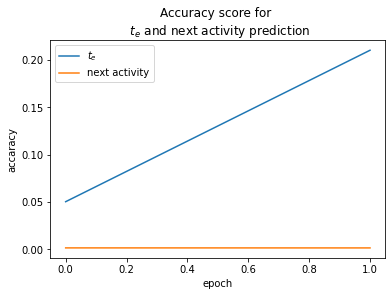

In [ ]:
te_rewards = []
ac_rewards = []
for epoch in range(30):
    te_rw, ac_rw, n = 0, 0, 0
    for _i in range(n_envs):
        print(f'{_i+1}/{n_envs}', end='\r')
        _ = envirs[_i].reset()
        with torch.no_grad():
                _episode_te_rew, _episode_ac_rew, n_ep = utils.play_and_record(agency.te_agent, agency.ac_agent,
                                                                               envirs[_i], replay_memory)
                te_rw += _episode_te_rew
                ac_rw += _episode_ac_rew
                n += n_ep
        if len(replay_memory) == replay_memory._maxsize:
            ep_te_loss, ep_ac_loss = agency.train(replay_memory, batch_size)
        # print(ep_te_rew, ep_te_rew, n_samples)
        
    ep_te_loss, ep_ac_loss = agency.train(replay_memory, batch_size)
    n = batch_size * n_envs
    te_rewards.append(te_rw / n)
    ac_rewards.append(ac_rw / n)
    
    display.clear_output(wait=True)
    plt.plot(te_rewards, label='$t_e$')
    plt.plot(ac_rewards, label='next activity')
    plt.xlabel('epoch')
    plt.ylabel('accaracy')
    plt.title('Accuracy score for \n $t_e$ and next activity prediction')
    plt.legend()
    plt.show()

In [ ]:
1193984 / 64 / 4664

In [ ]:
replay_memory.traces

In [ ]:
int(len(replay_memory) * 0.8 )

In [ ]:
reload(agencies)
agency = agencies.Agency(input_size=27 * 2, hidden=hidden, n_lstm=1, te_intervals=te_intervals, ac_learning_rate=1e-3,
                         te_learning_rate=1e-3, n_classes=n_classes, discount_factor=0.9)
ep_te_loss, ep_ac_loss = agency.train(replay_memory, batch_size)

In [ ]:
replay_memory._storage[0].obs_t.state.shape

In [ ]:
plt.plot(ac_rewards)
plt.xlabel('epoch')
plt.ylabel('accaracy')
plt.title('Accuracy score for \n $t_e$ prediction')

In [ ]:
states, actions_te, actions_ac, rewards_te, rewards_ac, next_states, is_dones = replay_memory.sample(256)

In [ ]:
states, actions_te, actions_ac, rewards_te, rewards_ac, next_states, is_dones = buffers[0].sample(5)

In [ ]:
s = envirs[0].reset()

In [ ]:
reload(envs)
reload(utils)

env_matrix = utils.get_traces_matrix(df, ix_4_envs[6])
env = envs.PMEnv(data=env_matrix, intervals_te_rew=te_intervals,
                 column_to_time_features=column_feature, window_size=window_size)
               
buffer = utils.ReplayMemory(2 ** 12)

episode_te_rew, episode_ac_rew, n = utils.play_and_record(agency.te_agent, agency.ac_agent,  env, buffer)

In [ ]:
episode_te_rew

In [ ]:
episode_ac_rew

In [ ]:
n

In [ ]:
n_traces = s.shape[0]
s = s.view(n_traces, 1, -1).float()
h_a = torch.zeros(1, n_traces, agency.te_agent.hidden)
c_a = torch.zeros(1, n_traces, agency.te_agent.hidden)
te_n = agency.te_agent.sample_action(s, (h_a, c_a))[0]

In [ ]:
x = 0

In [ ]:
t = torch.tensor([0, 0, 1])

In [ ]:
for _ in range(6):
    x += t

In [ ]:
x

In [ ]:
te_te_pred = agency.te_agent.act_to_te(te_n)
te_te_pred

In [ ]:
te_n, te_n.shape

In [ ]:
agency.te_agent

In [ ]:
true_tes = envirs[0].data[:, window_size+1, 0]

In [ ]:
answers = []
for _i, te in enumerate(true_tes):
    app = False
    for te_num, te_int in enumerate(te_intervals):
        if (te >= te_int[0]) & (te < te_int[1]):
            answers.append(te_num)
            app = True
    if not app:
        answers.append(-1)
answers = torch.tensor(answers)

In [ ]:
len(answers)

In [ ]:
answers, answers.shape

In [ ]:
(answers == te_n).sum()

In [ ]:
def get_te_reward(true: torch.tensor, pred: torch.tensor, te_intervals):
    masks = []
    for inter in intervals:
        true_here = (true >= inter[0]) * (true < inter[1])
        pred_here = (pred >= inter[0]) * (pred < inter[1])
        masks.append(true_here * pred_here)
    out = torch.stack(masks).T.sum(dim=1)
    return out

In [ ]:
get_te_reward(true=true_tes, pred=te_te_pred, intervals=te_intervals).sum()

In [ ]:
ep_te_rew

In [ ]:
ep_te_rew